In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from data.data_preprocessing import load_data, text_cleaning
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
from gensim.models import Word2Vec
import joblib
import os


# Load data

In [26]:
df = load_data('data/intents.csv')

In [27]:
df.head()

,sentence,intent
0,Lịch học hôm nay của tôi là gì?,lich_hoc
1,Cho tôi xem thời khóa biểu tuần này.,lich_hoc
2,Ngày mai tôi có tiết học nào không?,lich_hoc
3,TKB của tui tuần sau như thế nào?,lich_hoc
4,Hôm nay tôi học môn gì và ở đâu?,lich_hoc


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602 entries, 0 to 601
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  602 non-null    object
 1   intent    602 non-null    object
dtypes: object(2)
memory usage: 9.5+ KB


In [29]:
df.describe()

,sentence,intent
count,602,602
unique,602,5
top,Học phí môn ITE303c là bao nhiêu?,diem_so
freq,1,167


# Preprocess data

In [30]:
df['sentence'] = df['sentence'].apply(lambda s: text_cleaning(s))

## Tokenize sentences


In [31]:
df['tokens'] = df['sentence'].apply(lambda s: s.split())


In [32]:
df.head()

,sentence,intent,tokens
0,lich hoc hom nay cua toi_la gi ?,lich_hoc,"[lich, hoc, hom, nay, cua, toi_la, gi, ?]"
1,cho toi xem thoi_khoa bieu tuan nay .,lich_hoc,"[cho, toi, xem, thoi_khoa, bieu, tuan, nay, .]"
2,ngay mai_toi co_tiet hoc nao khong ?,lich_hoc,"[ngay, mai_toi, co_tiet, hoc, nao, khong, ?]"
3,tkb cua tui tuan sau nhu_the nao ?,lich_hoc,"[tkb, cua, tui, tuan, sau, nhu_the, nao, ?]"
4,hom nay toi hoc mon_gi va o dau ?,lich_hoc,"[hom, nay, toi, hoc, mon_gi, va, o, dau, ?]"


# Target variable encoding

In [33]:
label_encoder = LabelEncoder()
df['intent_encoded'] = label_encoder.fit_transform(df['intent'])

In [34]:
df[['intent', 'intent_encoded']].value_counts()

intent     intent_encoded
diem_so    1                 167
lich_hoc   3                 130
diem_danh  0                 114
lich_thi   4                 100
hoc_phi    2                  91
Name: count, dtype: int64

# Split data

In [35]:
X_train_text, X_test_text, y_train, y_test, X_train_tokens, X_test_tokens = train_test_split(
    df['sentence'],
    df['intent_encoded'],
    df['tokens'],
    test_size=0.2,
    random_state=42,
    stratify=df['intent_encoded']
)

X_train_tokens = [tokens for tokens in X_train_tokens]
X_test_tokens = [tokens for tokens in X_test_tokens]


# Vectorize features

In [36]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)


## Word embedding features


In [37]:
embedding_size = 100
token_sequences = df['tokens'].tolist()

w2v_model = Word2Vec(
    sentences=token_sequences,
    vector_size=embedding_size,
    window=5,
    min_count=1,
    workers=4,
    sg=1,
    epochs=200,
    seed=42
)

def sentence_vector(tokens, model=w2v_model, dimension=embedding_size):
    valid_tokens = [token for token in tokens if token in model.wv.key_to_index]
    if not valid_tokens:
        return np.zeros(dimension)
    return np.mean(model.wv[valid_tokens], axis=0)

X_train_embed = np.vstack([sentence_vector(tokens) for tokens in X_train_tokens])
X_test_embed = np.vstack([sentence_vector(tokens) for tokens in X_test_tokens])


## Baseline models

Establish simple intent prediction references before the heavier classifiers.

In [38]:

baseline_models = {
    "Most Frequent Baseline": DummyClassifier(strategy='most_frequent'),
    "Stratified Baseline": DummyClassifier(strategy='stratified', random_state=42)
}

baseline_results = {}

for model_name, model in baseline_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    baseline_results[model_name] = {
        'model': model,
        'report': classification_report(y_test, y_pred, output_dict=True, zero_division=0),
        'accuracy': accuracy_score(y_test, y_pred),
        'confusion': confusion_matrix(y_test, y_pred)
    }

# Define models

In [39]:
models = {
    "Multinomial Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(random_state=42),
    "Support Vector Machine": SVC(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
}

# Train models

### A. Base Model

In [40]:
results = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results[model_name] = {
        'model': model,
        'report': classification_report(y_test, y_pred, output_dict=True, zero_division=0),
        'accuracy': accuracy_score(y_test, y_pred),
        'confusion': confusion_matrix(y_test, y_pred)
    }

### B. GridSearchCV

In [41]:
param_grids = {
    "Logistic Regression": {
        "C": np.logspace(-4,4,20),
        "solver": ["liblinear"],
    },
    "Support Vector Machine": {
        "C": [1, 5, 10]
    },
    "Random Forest": {
        "n_estimators": [100, 200, 300, 400, 500]
    }
}

In [42]:
results_grid = {}

for model_name, model in models.items():
    if model_name in param_grids:
        clf = GridSearchCV(model, param_grid = param_grids[model_name], cv = 3, verbose=False, n_jobs=-1)
        best_clf = clf.fit(X_train, y_train)
        model = best_clf.best_estimator_
        print("Best hyperparameters of", model_name, "is:", end=" ")
        try:
            print(model.best_params_)
        except:
            print(model)
    else:
        continue
    y_pred = model.predict(X_test)

    results_grid[model_name] = {
        'model': model,
        'report': classification_report(y_test, y_pred, output_dict=True, zero_division=0),
        'accuracy': accuracy_score(y_test, y_pred),
        'confusion': confusion_matrix(y_test, y_pred)
    }

Best hyperparameters of Logistic Regression is: LogisticRegression(C=np.float64(11.288378916846883), random_state=42,
                   solver='liblinear')
Best hyperparameters of Support Vector Machine is: SVC(C=5, random_state=42)
Best hyperparameters of Random Forest is: RandomForestClassifier(n_estimators=400, random_state=42)


## Embedding models


In [43]:

embedding_models = {
    "Logistic Regression (Embeddings)": LogisticRegression(max_iter=1000, random_state=42),
    "Support Vector Machine (Embeddings)": SVC(probability=True, random_state=42),
    "Random Forest (Embeddings)": RandomForestClassifier(random_state=42)
}

embedding_results = {}

for model_name, model in embedding_models.items():
    model.fit(X_train_embed, y_train)
    y_pred = model.predict(X_test_embed)

    embedding_results[model_name] = {
        'model': model,
        'report': classification_report(y_test, y_pred, output_dict=True, zero_division=0),
        'accuracy': accuracy_score(y_test, y_pred),
        'confusion': confusion_matrix(y_test, y_pred)
    }

# Evaluate models

In [44]:

metrics = []

def summarize_results(model_name, result, tuned=None, category='Trained Model'):
    precision = round(result['report']['weighted avg']['precision'], 3)
    recall = round(result['report']['weighted avg']['recall'], 3)
    f1 = round(result['report']['weighted avg']['f1-score'], 3)
    acc = round(result['accuracy'], 3)

    summary = {
        'Category': category,
        'Model': model_name,
        'Precision': precision,
        'Precision Tuned': None,
        'Recall': recall,
        'Recall Tuned': None,
        'F1-Score': f1,
        'F1-Score Tuned': None,
        'Accuracy': acc,
        'Accuracy Tuned': None
    }

    if tuned is not None:
        def format_with_delta(base_value, tuned_value):
            delta = round(tuned_value - base_value, 3)
            sign = '+' if delta >= 0 else '-'
            return f"{round(tuned_value, 3)} Δ{sign}{abs(delta)}"

        precision_tuned = round(tuned['report']['weighted avg']['precision'], 3)
        recall_tuned = round(tuned['report']['weighted avg']['recall'], 3)
        f1_tuned = round(tuned['report']['weighted avg']['f1-score'], 3)
        acc_tuned = round(tuned['accuracy'], 3)

        summary['Precision Tuned'] = format_with_delta(precision, precision_tuned)
        summary['Recall Tuned'] = format_with_delta(recall, recall_tuned)
        summary['F1-Score Tuned'] = format_with_delta(f1, f1_tuned)
        summary['Accuracy Tuned'] = format_with_delta(acc, acc_tuned)

    return summary

for model_name, result in baseline_results.items():
    metrics.append(summarize_results(model_name, result, category='Baseline'))

for model_name, result in results.items():
    tuned = results_grid.get(model_name)
    metrics.append(summarize_results(model_name, result, tuned=tuned))

for model_name, result in embedding_results.items():
    metrics.append(summarize_results(model_name, result, category='Embedding Model'))

metrics_df = pd.DataFrame(metrics)
metrics_df

,Category,Model,Precision,Precision Tuned,Recall,Recall Tuned,F1-Score,F1-Score Tuned,Accuracy,Accuracy Tuned
0,Baseline,Most Frequent Baseline,0.079,None,0.281,None,0.123,None,0.281,None
1,Baseline,Stratified Baseline,0.192,None,0.182,None,0.185,None,0.182,None
2,Trained Model,Multinomial Naive Bayes,0.922,None,0.917,None,0.916,None,0.917,None
3,Trained Model,Logistic Regression,0.953,0.976 Δ+0.023,0.950,0.975 Δ+0.025,0.951,0.975 Δ+0.024,0.950,0.975 Δ+0.025
4,Trained Model,Support Vector Machine,0.960,0.969 Δ+0.009,0.959,0.967 Δ+0.008,0.959,0.967 Δ+0.008,0.959,0.967 Δ+0.008
5,Trained Model,Random Forest,0.944,0.952 Δ+0.008,0.942,0.95 Δ+0.008,0.942,0.95 Δ+0.008,0.942,0.95 Δ+0.008
6,Embedding Model,Logistic Regression (Embeddings),0.967,None,0.967,None,0.967,None,0.967,None
7,Embedding Model,Support Vector Machine (Embeddings),0.967,None,0.967,None,0.967,None,0.967,None
8,Embedding Model,Random Forest (Embeddings),0.945,None,0.942,None,0.942,None,0.942,None


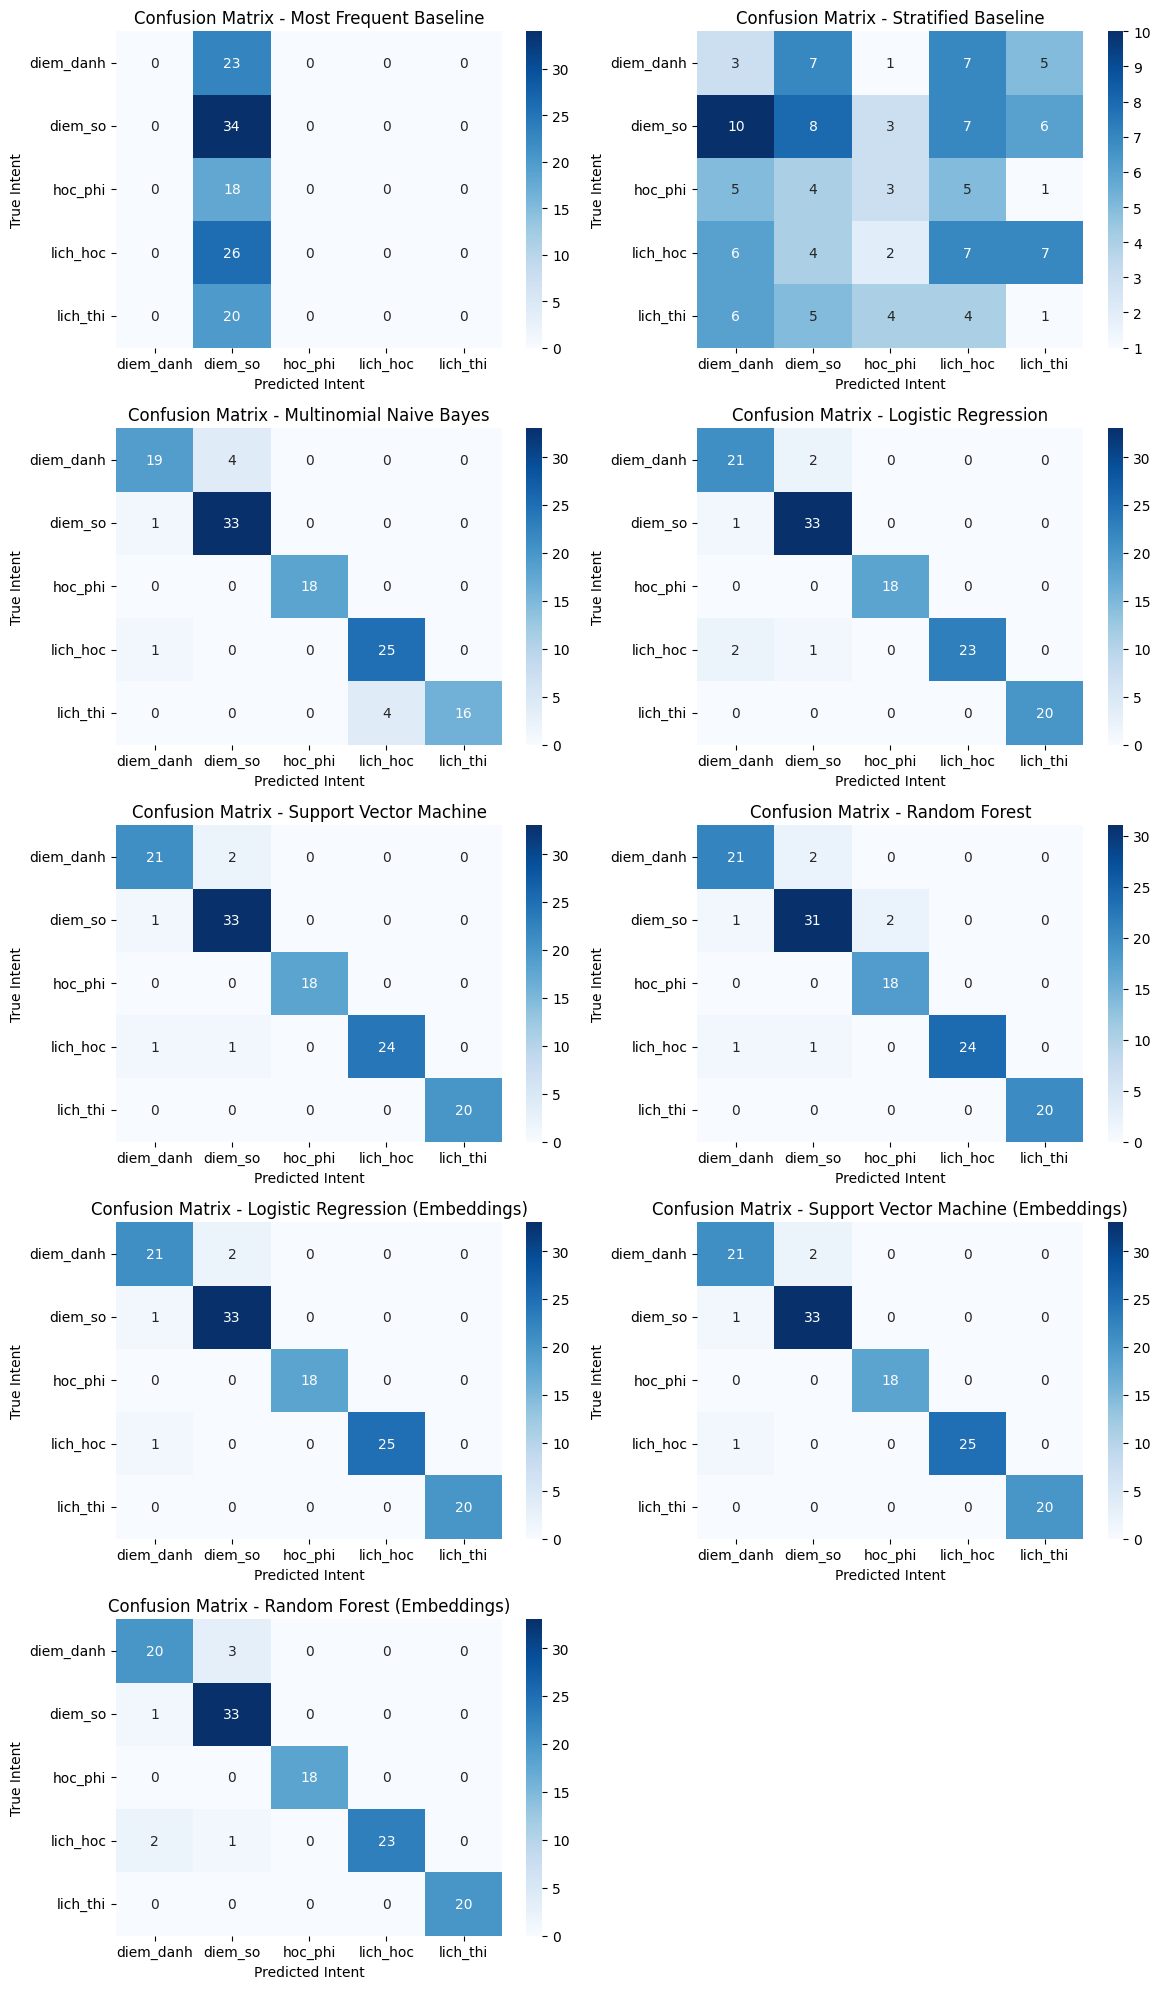

In [45]:

intent_classes = label_encoder.inverse_transform(np.unique(y_test))
combined_results = list(baseline_results.items()) + list(results.items()) + list(embedding_results.items())
n_models = len(combined_results)
cols = 2
rows = (n_models + cols - 1) // cols
plt.figure(figsize=(cols * 6, rows * 4))
for i, (model_name, results_) in enumerate(combined_results):
    plt.subplot(rows, cols, i + 1)
    sns.heatmap(results_['confusion'], annot=True, fmt="d", cmap="Blues", xticklabels=intent_classes, yticklabels=intent_classes)
    plt.xlabel('Predicted Intent')
    plt.ylabel('True Intent')
    plt.title(f'Confusion Matrix - {model_name}')
plt.tight_layout()
plt.show()

# Save model

In [46]:
tfidf_results = results.copy()

for model_name, tuned_result in results_grid.items():
    base_accuracy = tfidf_results.get(model_name, {}).get('accuracy', -1)
    if tuned_result['accuracy'] > base_accuracy:
        tfidf_results[model_name] = tuned_result

all_model_results = {**tfidf_results, **embedding_results}
best_model_name, best_model_data = max(all_model_results.items(), key=lambda item: item[1]['accuracy'])
model = best_model_data['model']
feature_type = 'embedding' if 'Embeddings' in best_model_name else 'tfidf'

os.makedirs('models', exist_ok=True)
joblib.dump(model, "models/best_model.pkl")
joblib.dump(label_encoder, "intent_encoding.pkl")

metadata = {
    'model_name': best_model_name,
    'feature_type': feature_type,
    'accuracy': round(best_model_data['accuracy'], 3)
}

if feature_type == 'tfidf':
    joblib.dump(vectorizer, "models/vectorizer.pkl")
    metadata['vectorizer'] = "models/vectorizer.pkl"
else:
    w2v_model.save("models/word2vec.model")
    metadata['word2vec'] = "models/word2vec.model"
    metadata['embedding_size'] = embedding_size

joblib.dump(metadata, "models/model_metadata.pkl")
print(f"Saved {best_model_name} ({feature_type}) with accuracy={best_model_data['accuracy']:.3f}")


Saved Logistic Regression (tfidf) with accuracy=0.975


# Test model

In [47]:
input_text = "check diem danh mon ail303m cua toi"

cleaned_text = text_cleaning(input_text)


def transform_input(text):
    if feature_type == 'tfidf':
        return vectorizer.transform([text])
    tokens = text.split()
    return np.expand_dims(sentence_vector(tokens), axis=0)


transformed_text = transform_input(cleaned_text)

predicted_intent = model.predict(transformed_text)
predicted_intent_label = label_encoder.inverse_transform(predicted_intent)[0]

if hasattr(model, "predict_proba"):
    predicted_proba = model.predict_proba(transformed_text)[0]
elif hasattr(model, "decision_function"):
    decision_scores = model.decision_function(transformed_text)
    if decision_scores.ndim == 1:
        decision_scores = np.expand_dims(decision_scores, axis=0)
    stabilized = decision_scores - decision_scores.max(axis=1, keepdims=True)
    exp_scores = np.exp(stabilized)
    predicted_proba = (exp_scores / exp_scores.sum(axis=1, keepdims=True))[0]
else:
    predicted_proba = np.ones(len(model.classes_)) / len(model.classes_)

predicted_confidence = float(np.max(predicted_proba) * 100)
class_labels = label_encoder.inverse_transform(model.classes_)

print(f"Predicted intent: {predicted_intent_label} (model: {best_model_name})")
print(f"Confidence: {predicted_confidence:.2f}%")
print("\nPer-intent probabilities:")
for intent_label, proba in zip(class_labels, predicted_proba):
    print(f"- {intent_label}: {proba * 100:.2f}%")


Predicted intent: diem_danh (model: Logistic Regression)
Confidence: 87.65%

Per-intent probabilities:
- diem_danh: 87.65%
- diem_so: 2.49%
- hoc_phi: 0.16%
- lich_hoc: 8.51%
- lich_thi: 1.19%
